In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk

In [2]:
def parse_txt(file_path):
    graphs = []  
    current_matrix = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith("Graph"):
                if current_matrix:
                    adj_matrix = np.array(current_matrix, dtype=int)
                    G = nx.from_numpy_array(adj_matrix)
                    for u, v in G.edges():
                        G[u][v]['weight'] = random.randint(1, 10) 
                    graphs.append(G)
                    current_matrix = [] 
            
            elif line:  
                    current_matrix.append([int(char) for char in line])
            
        if current_matrix:
            adj_matrix = np.array(current_matrix, dtype=int)
            G = nx.from_numpy_array(adj_matrix)
            for u, v in G.edges():
                G[u][v]['weight'] = random.randint(1, 10)
            graphs.append(G)
            
        return graphs

In [3]:
def visualize_all_graphs(graphs):
    i = 1  
    for graph in graphs:
        plt.figure(figsize=(6, 6))
        
        pos = nx.spring_layout(graph, seed=42) 
        
        nx.draw(graph, pos, with_labels=True, node_color='pink', edge_color='gray')
        
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        plt.title(f"Graph {i}")
        
        plt.show()
        i += 1
        



In [4]:
def prim_mst(G):
    
    start_node = list(G.nodes())[0]  
    visited = set([start_node])
    
    edges = [
        (G[start_node][dest]["weight"], start_node, dest)
        for dest in G[start_node]
    ]
    heapq.heapify(edges)  
    mst = []
    steps = [] 
    
    while edges and len(visited) < len(G.nodes):
        weight, src, dest = heapq.heappop(edges)
        if dest in visited:
            continue
        visited.add(dest)
        mst.append((weight, src, dest))
        steps.append(list(mst))
        
        
        for neighbor, edge_attr in G[dest].items():
            if neighbor not in visited:
                edge_weight = edge_attr["weight"]
                heapq.heappush(edges, (edge_weight, dest, neighbor))
    
    return mst, steps


In [5]:
def kruskal_mst(G):
    
    edges = [
        (G[u][v]["weight"], u, v) for u, v in G.edges()
    ]
    heapq.heapify(edges)
    mst = []
    steps = []

    parent = {node: node for node in G.nodes()}
    rank = {node: 0 for node in G.nodes()}
    
    def find(node):

        if parent[node] != node:
            parent[node] = find(parent[node])
        return parent[node]
    
    def union(node1, node2):
        root1, root2 = find(node1), find(node2)
        if root1 != root2:
            if rank[root1] > rank[root2]:
                parent[root2] = root1
            elif rank[root1] < rank[root2]:
                parent[root1] = root2
            else:
                parent[root2] = root1
                rank[root1] += 1
    
 
    while edges and len(mst) < len(G.nodes()) - 1:
        weight, u, v = heapq.heappop(edges)
        if find(u) != find(v): 
            union(u, v)
            mst.append((weight, u, v))
            steps.append(list(mst)) 
    
    return mst, steps

In [6]:
graphs = parse_txt("graph_output.txt")

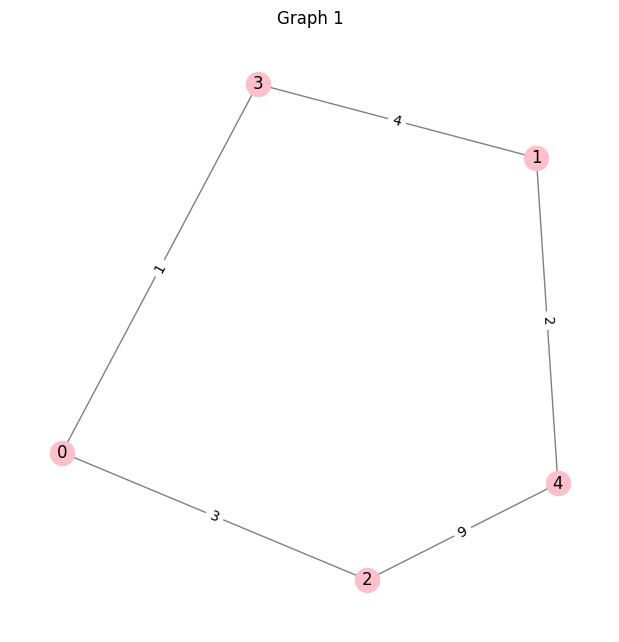

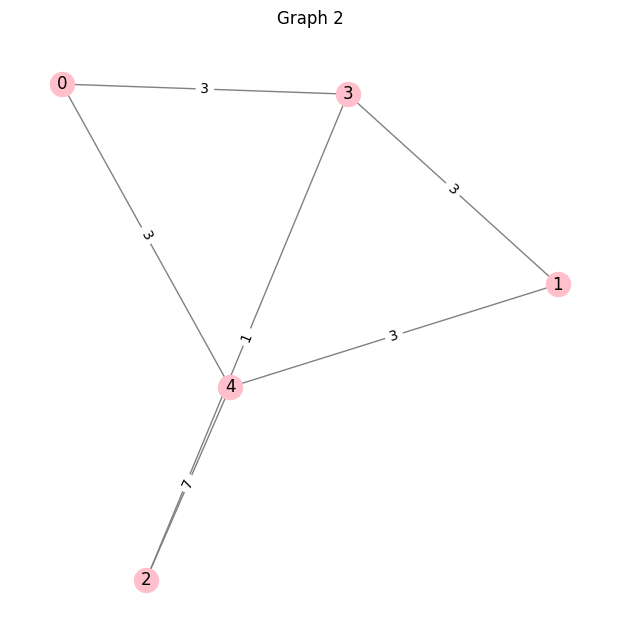

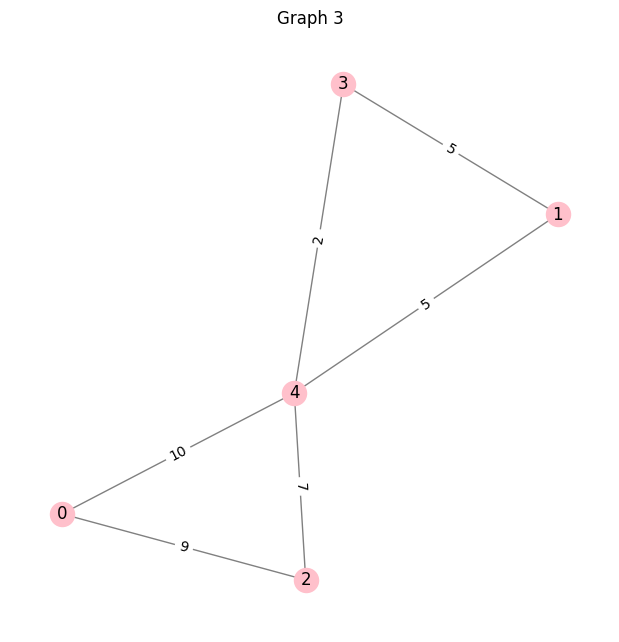

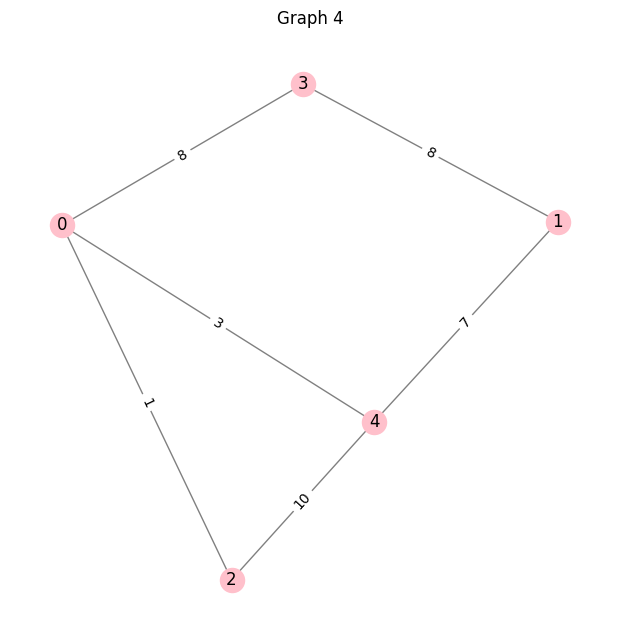

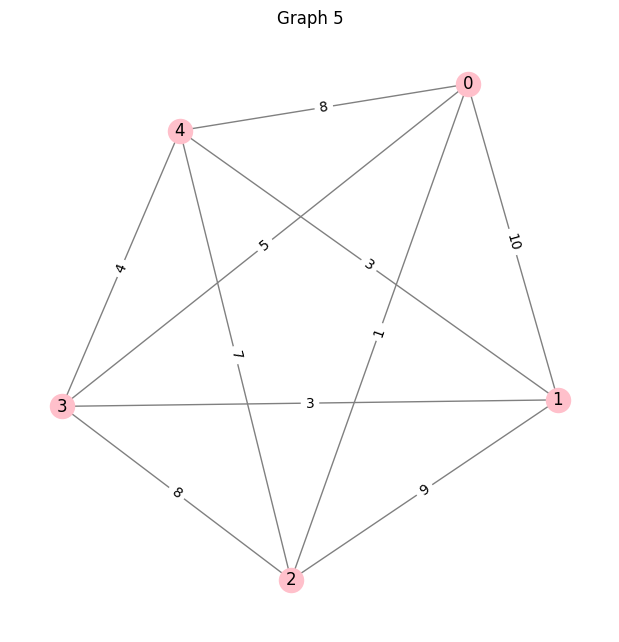

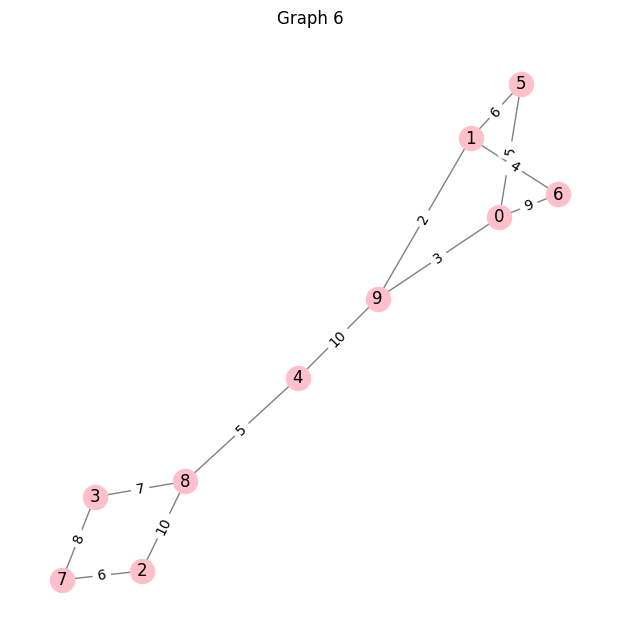

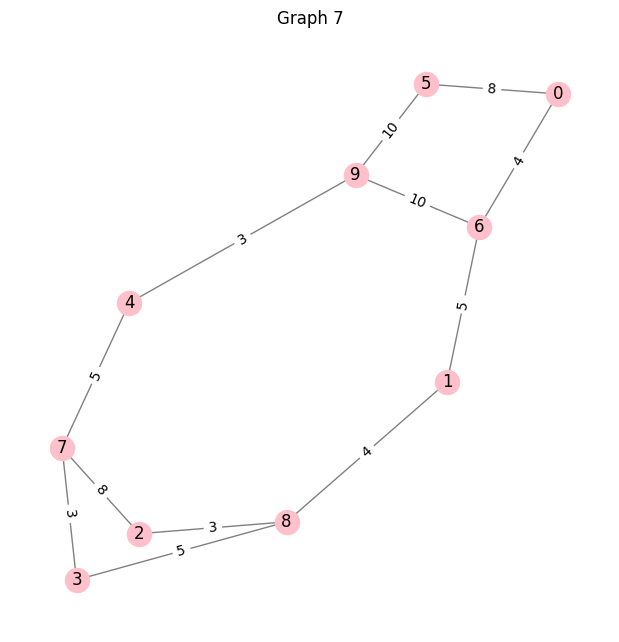

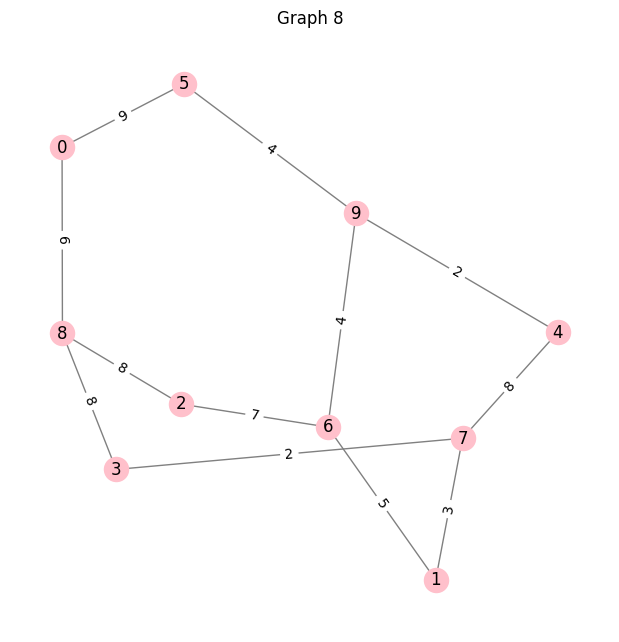

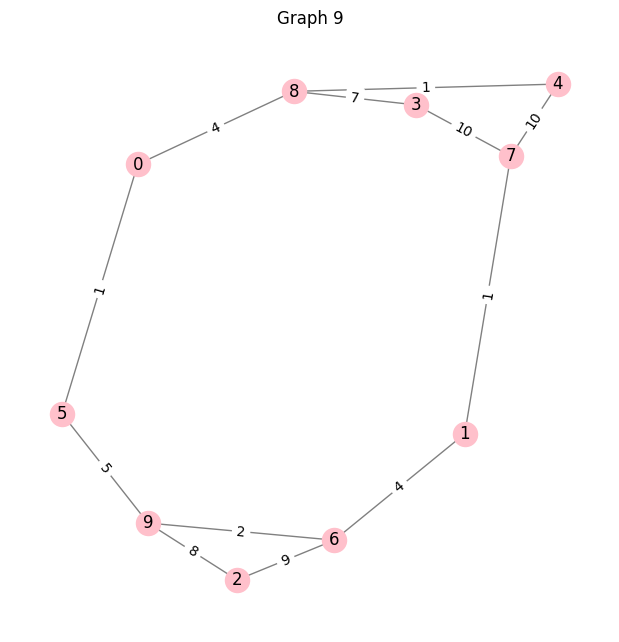

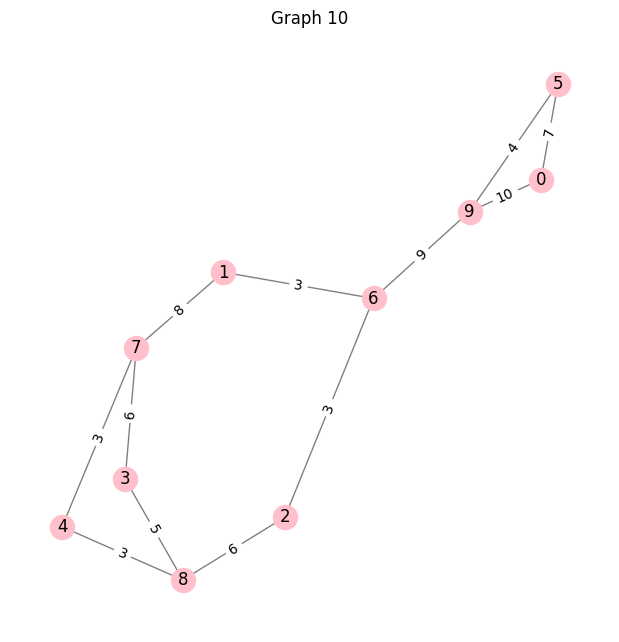

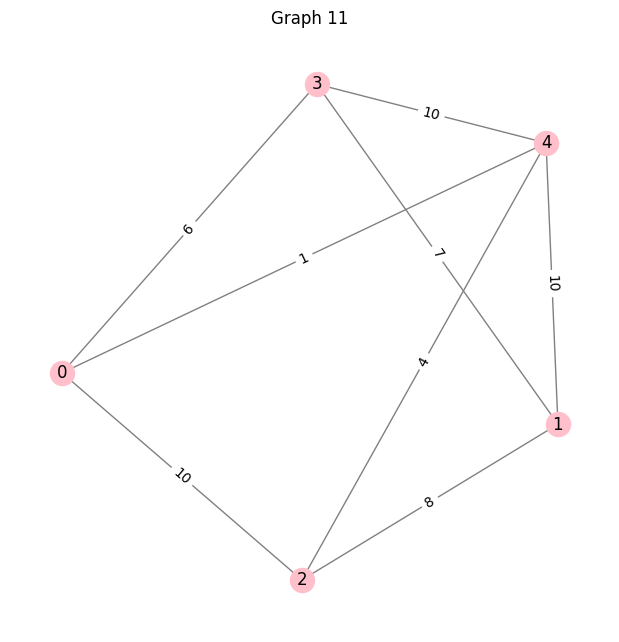

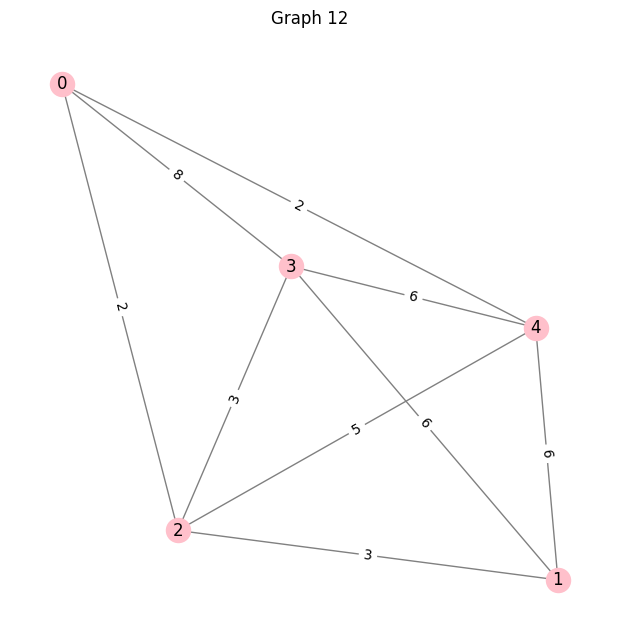

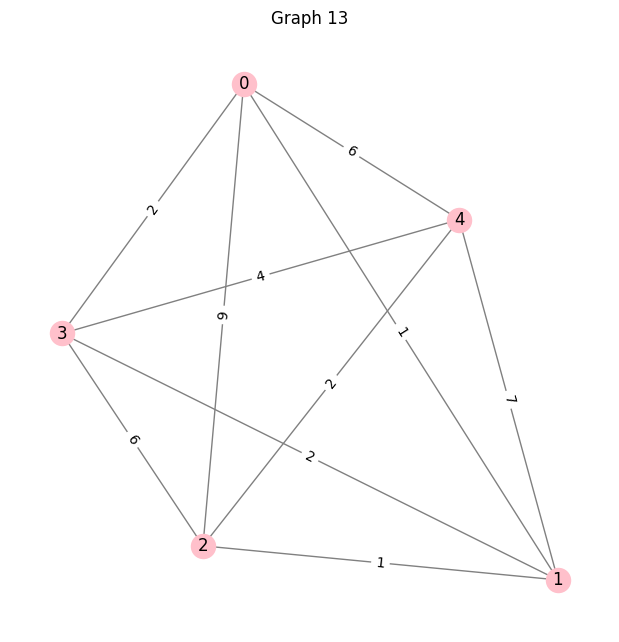

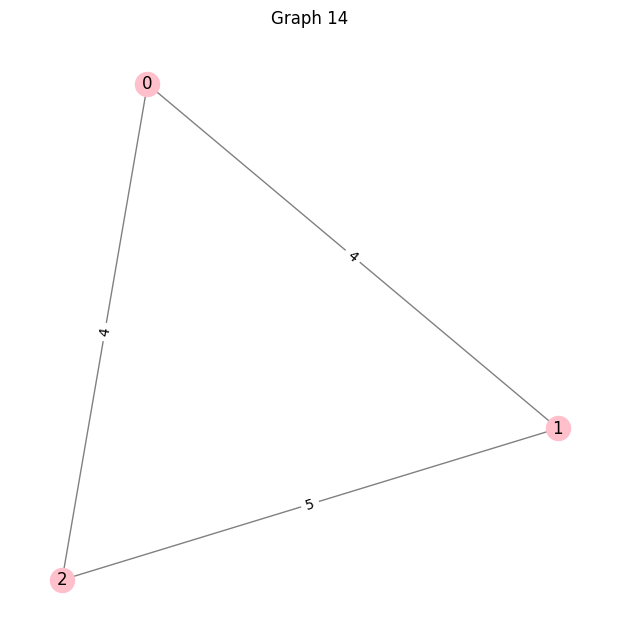

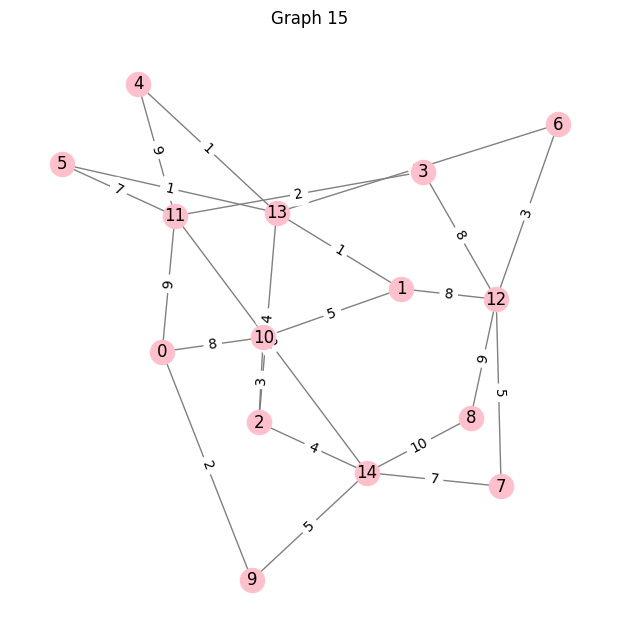

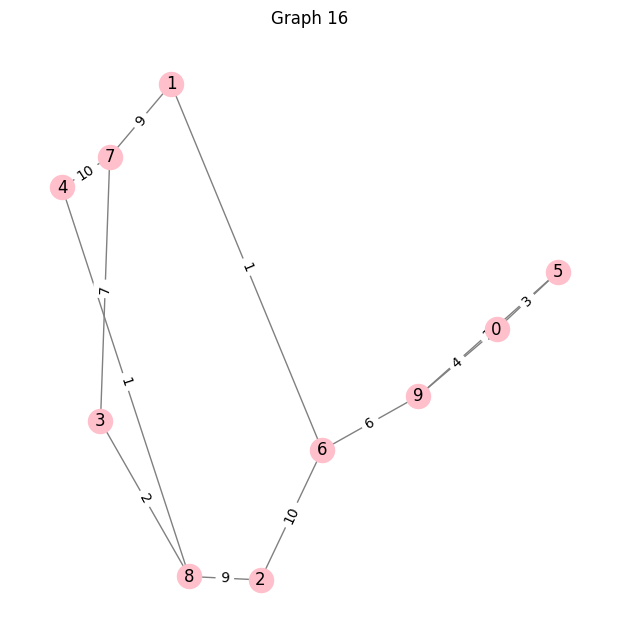

In [7]:
visualize_all_graphs(graphs)

In [8]:
# i = 1  
# for graph in graphs:
#     mst_edges = prim_mst(graph)
#     print(f"MST for Graph {i}:", mst_edges)
#     i += 1  


In [66]:
def update_graph(graph, steps, step_index, canvas, ax):
    ax.clear()  

    pos = nx.spring_layout(graph, seed=42)  
    edge_labels = nx.get_edge_attributes(graph, 'weight')  

   
    visited_nodes = set()
    mst_edges = []

    
    if step_index > 0:  
        current_edges = steps[step_index - 1]
        for edge in current_edges:
            weight, src, dest = edge
            visited_nodes.add(src)  
            visited_nodes.add(dest)
            mst_edges.append((src, dest))  

    
    node_colors = []  =

    for node in graph.nodes():  
        if node in visited_nodes:
            node_colors.append('red')  
        else:
            node_colors.append('pink')  


   
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color='gray', ax=ax)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax)

    
    if mst_edges:
        nx.draw_networkx_edges(graph, pos, edgelist=mst_edges, edge_color='red', width=2, ax=ax)
        
    if step_index == 0:  
        diameter = calculate_diameter(graph)
        ax.set_title( f"Diameter of Original Graph = {diameter}")


    
    canvas.draw()

In [67]:
def calculate_diameter(graph, mst_edges=None):
    if mst_edges:
        
        mst_graph = nx.Graph()
        for weight, src, dest in mst_edges:
            mst_graph.add_edge(src, dest, weight=weight)
       
        return nx.diameter(mst_graph, weight='weight')
    else:
       
        return nx.diameter(graph, weight='weight')

In [69]:
def plot_graph_gui(graphs):
    current_graph_index = [0]
    mst = None
    steps = None
    current_step_index = [0]
    is_mst_view = [False]
    
    
    window = tk.Tk()
    window.title("MST Visualization") 
    selected_algorithm = tk.StringVar(value="Prim's")
    

    def load_graph(index):
        nonlocal mst, steps, current_step_index
        current_step_index[0] = 0
        current_graph_index[0] = index
        graph = graphs[index]
        
        if selected_algorithm.get() == "Prim's":
            mst, steps = prim_mst(graph)
        elif selected_algorithm.get() == "Kruskal's":
            mst, steps = kruskal_mst(graph)
            
        update_graph(graph, steps, current_step_index[0], canvas, ax)
        update_table(current_step_index[0])
        graph_diameter = calculate_diameter(graph)
        
        status_label.config(text="")
        graph_diameter_label.config(text="")
        mst_diameter_label.config(text="")


        show_mst_button.pack_forget()


    def update_table(step_index):
        table.delete(*table.get_children())
        mst_weight_total = 0
        
        if step_index > 0:
            current_edges = steps[step_index - 1]
            cumulative_weight = 0
            step_number = 1
            
            for weight, src, dest in current_edges:
                cumulative_weight += weight
                table.insert('', 'end', values=(step_number, src, dest, weight, cumulative_weight))
                step_number += 1 
                
            mst_weight_total = cumulative_weight
        mst_weight_label.config(text=f"MST Weight Total: {mst_weight_total}")

    def next_step():
        if current_step_index[0] < len(steps):
            current_step_index[0] += 1
            update_graph(graphs[current_graph_index[0]], steps, current_step_index[0], canvas, ax)
            update_table(current_step_index[0])  

            if current_step_index[0] == len(steps):
                canvas.draw()
                status_label.config(text="The full MST has been determined!")
                current_graph = graphs[current_graph_index[0]]
                graph_diameter=calculate_diameter(current_graph)
                graph_diameter_label.config(text=f"Original Graph Diameter: {graph_diameter}")
                mst_diameter = calculate_diameter(current_graph, mst_edges=steps[-1])
                mst_diameter_label.config(text=f"MST Diameter: {mst_diameter}")
                show_mst_button.pack(side=tk.BOTTOM, pady=5)

                
    def prev_step():
        if current_step_index[0] > 0:
            current_step_index[0] -= 1
            update_graph(graphs[current_graph_index[0]], steps, current_step_index[0], canvas, ax)
            update_table(current_step_index[0]) 
            
            status_label.config(text="")
            graph_diameter_label.config(text="")
            mst_diameter_label.config(text="")
            show_mst_button.pack_forget()

            
    def toggle_mst_view():
        if is_mst_view[0]:  
            is_mst_view[0] = False  
            update_graph(graphs[current_graph_index[0]], steps, current_step_index[0], canvas, ax)
            show_mst_button.config(text="Show MST Only")
        else:  
            is_mst_view[0] = True  
            show_mst_only()
            show_mst_button.config(text="Show Full Graph")


    def show_mst_only():
        ax.clear()
        pos = nx.spring_layout(graphs[current_graph_index[0]], seed=42)
        
        
        mst_edges = []
        visited_nodes = set()

        for _, src, dest in steps[-1]:
            mst_edges.append((src, dest))  
            visited_nodes.add(src)  
            visited_nodes.add(dest)  



        nx.draw_networkx_nodes(graphs[current_graph_index[0]], pos, node_color='red', ax=ax)
        nx.draw_networkx_labels(graphs[current_graph_index[0]], pos, ax=ax)
        nx.draw_networkx_edges(graphs[current_graph_index[0]], pos, edgelist=mst_edges, edge_color='red', width=2, ax=ax)

        edge_labels = {(src, dest): weight for weight, src, dest in steps[-1]}
        nx.draw_networkx_edge_labels(graphs[current_graph_index[0]], pos, edge_labels=edge_labels, ax=ax)

        ax.set_axis_off()
        canvas.draw()

    
    main_frame = tk.Frame(window)
    main_frame.pack(fill=tk.BOTH, expand=True)

    graph_frame = tk.Frame(main_frame)
    graph_frame.pack(fill=tk.BOTH, side=tk.LEFT, expand=True)

    table_frame = tk.Frame(main_frame, width=200)
    table_frame.pack(fill=tk.BOTH, side=tk.RIGHT)

    
    fig, ax = plt.subplots(figsize=(6, 4))
    canvas = FigureCanvasTkAgg(fig, master=graph_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    algorithm_frame = tk.Frame(graph_frame)
    algorithm_frame.pack(pady=5)
    
    graph_options = [f"Graph {i+1}" for i in range(len(graphs))]
    selected_graph = tk.StringVar(window)
    selected_graph.set(graph_options[0])

    dropdown = tk.OptionMenu(graph_frame, selected_graph, *graph_options, command=lambda val: load_graph(graph_options.index(val)))
    dropdown.pack(pady=5)
    

    tk.Label(algorithm_frame, text="Select Algorithm:", font=("Arial", 10)).pack(side=tk.LEFT)
    tk.Radiobutton(algorithm_frame, text="Prim's", variable=selected_algorithm, value="Prim's", command=lambda: load_graph(current_graph_index[0])).pack(side=tk.LEFT)
    tk.Radiobutton(algorithm_frame, text="Kruskal's", variable=selected_algorithm, value="Kruskal's", command=lambda: load_graph(current_graph_index[0])).pack(side=tk.LEFT)


    table = ttk.Treeview(table_frame, columns=('step', 'source', 'dest', 'weight', 'c_weight'), show='headings', height=15)
    table.heading('step', text='Step')  
    table.heading('source', text='Source')
    table.heading('dest', text='Destination')
    table.heading('weight', text='Weight')
    table.heading('c_weight', text='Cumulative Weight')
    
    table.column('step', width=50)
    table.column('source', width=100)
    table.column('dest', width=100)
    table.column('weight', width=100)
    table.column('c_weight', width=100)
    table.pack(fill=tk.BOTH, expand=True)

    
    status_label = tk.Label(graph_frame, text="", font=("Arial", 24), fg="red")
    status_label.pack(pady=5)
    
    mst_weight_label = tk.Label(graph_frame, text="", font=("Arial", 16), fg="blue")
    mst_weight_label.pack(pady=2)

    graph_diameter_label = tk.Label(graph_frame, text="", font=("Arial", 16), fg="red")
    graph_diameter_label.pack(pady=2)

    mst_diameter_label = tk.Label(graph_frame, text="", font=("Arial", 16), fg="red")
    mst_diameter_label.pack(pady=2)

    button_frame = tk.Frame(graph_frame)
    button_frame.pack(fill=tk.X, side=tk.BOTTOM, pady=5)

    prev_button = tk.Button(button_frame, text="Prev", command=prev_step)
    prev_button.pack(side=tk.LEFT, padx=10)

    show_mst_button = tk.Button(button_frame, text="Show MST Only", command=toggle_mst_view, width=24, height= 3)
    show_mst_button.pack(side=tk.LEFT, padx=10)
    show_mst_button.pack_forget()

    next_button = tk.Button(button_frame, text="Next", command=next_step)
    next_button.pack(side=tk.RIGHT, padx=10)

    load_graph(0)
    window.mainloop()




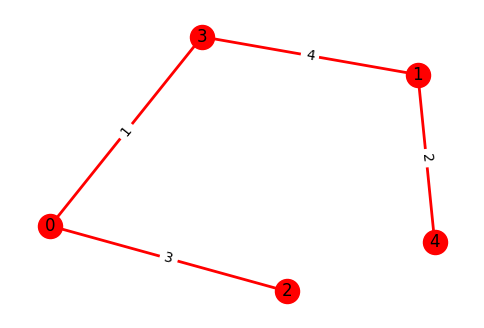

In [71]:
plot_graph_gui(graphs)